# **Fine Tune GPT 2 on Custom Dataset**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [5]:
!pip install transformers_interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 851.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00


### **Import Libraries**

In [ ]:
import numpy as np
import re
import os
import pandas as pd
import json
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2Tokenizer, GPT2TokenizerFast, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import transformers_interpret
import torch
from transformers_interpret import SequenceClassificationExplainer
# from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

### **Data Formatting**

In [ ]:
# Load the dataset from the XLSX file
training_file_path = '/content/drive/MyDrive/Research_Project/Codes/train_new_data.csv'
validation_file_path = '/content/drive/MyDrive/Research_Project/Codes/validation_new_data.csv'
df = pd.read_csv(training_file_path, usecols=lambda x: x != 'Type',nrows=3000)
df_val = pd.read_csv(validation_file_path, usecols=lambda x: x != 'Type',nrows=750)

# Convert the dataset to a list of dictionaries
data = df.to_dict(orient='records')
val_data = df_val.to_dict(orient='records')

# # Save the data in JSON format
# json_file_path = 'output1.json'  # Replace with the desired output file path
# with open(json_file_path, 'w') as json_file:
#     json.dump(data, json_file, indent=4)


In [ ]:
print("Number of rows:", df.shape[0])

Number of rows: 3000


In [ ]:
# Convert the data to the desired format
formatted_data = []
for item in data:
    formatted_data.append(f"[Q] {item['question']}")
    formatted_data.append(f"[A] {item['answer']}")

# Save the data in JSON format
json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSON2GPT2/D3000/output.json'  # Replace with the desired output file path
with open(json_file_path, 'w') as json_file:
    json.dump(formatted_data, json_file, indent=4)

# Convert the data to the desired format
val_formatted_data = []
for item in val_data:
    val_formatted_data.append(f"[Q] {item['question']}")
    val_formatted_data.append(f"[A] {item['answer']}")

# Save the data in JSON format
val_json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSON2GPT2/D3000/val_output.json'  # Replace with the desired output file path
with open(val_json_file_path, 'w') as json_file:
    json.dump(val_formatted_data, json_file, indent=4)

### **Fine-tuning**

In [ ]:
json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSON2GPT2/D3000/output.json'
val_json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSON2GPT2/D3000/val_output.json'

In [ ]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

In [ ]:
def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

In [ ]:
def compute_metrics(p):
    return {"accuracy": (p.predictions.argmax(-1) == p.label_ids).float().mean().item()}


In [ ]:
def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  train_dataset = load_dataset(train_file_path, tokenizer)
  data_collator = load_data_collator(tokenizer)

  tokenizer.save_pretrained(output_dir)

  model = GPT2LMHeadModel.from_pretrained(model_name)

  model.save_pretrained(output_dir)

  training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        evaluation_strategy="steps",
        eval_steps=save_steps,
        save_steps=save_steps,
        logging_steps=save_steps,
        save_total_limit=2,
        load_best_model_at_end=True,
    )

  trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        compute_metrics=compute_metrics,
    )

  trainer.train()
  trainer.save_model()

In [ ]:
train_file_path = json_file_path
eval_dataset =val_json_file_path
model_name = 'gpt2' # here we can use a bigger model like gpt2-medium, gpt2-large etc
output_dir = '/content/drive/MyDrive/Research_Project/Codes/Result2GPT2/D3000'
overwrite_output_dir = False
# per_device_train_batch_size = 1
per_device_train_batch_size = 8
num_train_epochs = 24
save_steps = 5000

In [ ]:
trainer = train(
    train_file_path=train_file_path,
    model_name=model_name,
    eval_file_path=val_json_file_path,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

TypeError: train() got an unexpected keyword argument 'eval_file_path'

In [5]:
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, GPT2LMHeadModel
from transformers import TextDataset, DataCollatorForLanguageModeling

json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSON2GPT2/D3000/output.json'
val_json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSON2GPT2/D3000/val_output.json'

def load_dataset(file_path, tokenizer, block_size=128):
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size,
    )
    return dataset

def load_data_collator(tokenizer, mlm=False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

def compute_metrics(p):
    return {"perplexity": p.metrics["eval_loss"]}

gradient_accumulation_steps = 4  # Accumulate gradients over multiple steps
per_device_train_batch_size = 2  # Adjust according to your GPU memory

def train(train_file_path, eval_file_path, model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):

    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    train_dataset = load_dataset(train_file_path, tokenizer)
    eval_dataset = load_dataset(eval_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)

    model = GPT2LMHeadModel.from_pretrained(model_name)

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        num_train_epochs=num_train_epochs,
        evaluation_strategy="steps",  # Evaluate every save_steps steps
        save_strategy="steps",  # Save model every save_steps steps
        eval_steps=save_steps,
        save_steps=save_steps,
        logging_steps=save_steps,
        save_total_limit=2,
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    trainer.save_model()



train_file_path = json_file_path
eval_file_path = val_json_file_path
model_name = 'gpt2'  # here we can use a bigger model like gpt2-medium, gpt2-large etc
output_dir = '/content/drive/MyDrive/Research_Project/Codes/Result2GPT2/D3000'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 12
save_steps = 5000

train(
    train_file_path=train_file_path,
    eval_file_path=eval_file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 21154 has 14.74 GiB memory in use. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 23.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
import torch

torch.cuda.empty_cache()


### **Check Model Performence**

In [ ]:
training_acc = trainer.evaluate()["eval_accuracy"]
training_loss = trainer.evaluate()["eval_loss"]
print(f"Training Accuracy: {training_acc}")
print(f"Training Loss: {training_loss}")

AttributeError: 'NoneType' object has no attribute 'evaluate'

In [ ]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
val_dataset = load_dataset(val_json_file_path, tokenizer)
val_data_collator = load_data_collator(tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=False,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
    ),
    data_collator=val_data_collator,
    eval_dataset=val_dataset,
)
trainer.evaluate()

{'eval_loss': 0.4820074439048767,
 'eval_runtime': 1.4621,
 'eval_samples_per_second': 91.648,
 'eval_steps_per_second': 11.627}

In [ ]:
# Load the validation dataset
val_json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSON2GPT2/B8E24/val_output.json'
val_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=val_json_file_path,
    block_size=128,
)

In [ ]:
# Define the data collator
val_data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Set mlm to False for causal language modeling
)

# Evaluate the model on the validation dataset
results = trainer.evaluate()

In [ ]:
# Calculate accuracy
accuracy = results["eval_loss"]  # Assuming you use loss as a metric for evaluation
print(f"Validation Loss: {accuracy}")

# Calculate accuracy
accuracy = 1.0 - results["eval_loss"]  # Assuming lower loss is better
print(f"Validation Accuracy: {accuracy}")

Validation Loss: 0.4820074439048767
Validation Accuracy: 0.5179925560951233


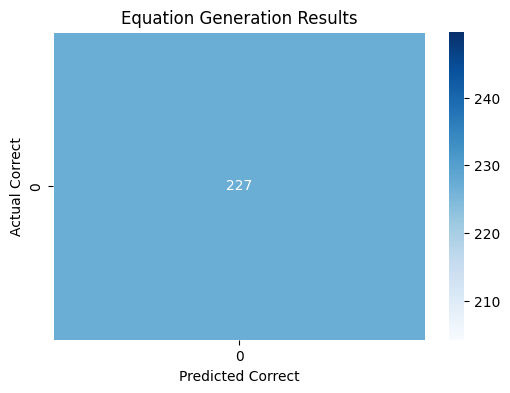

In [ ]:
# # Replace this with the path to your JSON file
# val_json_file_path = '/content/drive/MyDrive/Research_Project/Codes/JSONGPT2/val_output.json'

# Read the JSON file into a list
with open(val_json_file_path, 'r') as json_file:
    validation_output = json.load(json_file)

# Process the validation output into a DataFrame
data = {'Question': [], 'GroundTruthEquation': [], 'GeneratedEquation': []}

for i in range(0, len(validation_output), 2):
    question = validation_output[i].split('[Q] ')[1]
    equation = validation_output[i + 1].split('[E] ')[1]
    data['Question'].append(question)
    data['GroundTruthEquation'].append(equation)
    data['GeneratedEquation'].append(validation_output[i + 1])

df_results = pd.DataFrame(data)

# Create a binary column for correctness
df_results['Correct'] = df_results['GroundTruthEquation'] == df_results['GeneratedEquation']

# Visualize correctness using a confusion matrix-like heatmap
conf_matrix = confusion_matrix(df_results['Correct'], df_results['Correct'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=True, linewidths=.5)
plt.title('Equation Generation Results')
plt.xlabel('Predicted Correct')
plt.ylabel('Actual Correct')
plt.show()


### **Get Model Predictions**

In [ ]:
# Load the fine-tuned model
model_name = '/content/drive/MyDrive/Research_Project/Codes/Result2GPT2/B8E3'
model = GPT2LMHeadModel.from_pretrained(model_name, local_files_only=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Input question
input_question = "A farmer has 120 acres of land. He plants corn on 3/4 of the land and soybeans on the rest. How many more acres of corn than soybeans does he plant?"
# Encode the input question
input_ids = tokenizer.encode(f"[Q] {input_question}", return_tensors="pt")

# Generate the equation
output = model.generate(input_ids, max_length=500, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0)
generated_equation = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_equation)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Q] A farmer has 120 acres of land. He plants corn on 3/4 of the land and soybeans on the rest. How many more acres of corn than soybeans does he plant?",
   "[E] Let's denote the number of acres planted as \\( x \\) and the total amount he has to pay for all the corn and corn seeds. According to the information given:\n\n\\[ x = \\frac{120}{3.4} \\times 3x = 120 + 120 = 180 \\]\na = 90 \\text{ acres} \u00f7 90 = 360 \\nx \\cdot 360 = 0.5 \\)\na \\approx \\sqrt{180}{360} = 1.25 \\\nn = 2.75 \\}\nt = 3.375 \\% of \\[ \\left(x - 360)}{2.875} + \\right)(x + 180) = -1.125 \\\\\nz = 4.625 \\^2 + -0.05 \\nz \\u03c0 = 5.075 \\)\ny = 6.025 \\pi = 9.975 \\nn \\nd = 7.325 \\).\nb = (6.275 - -5) + (7.475 -6) \\nr = 8.825 \\nb \\nw = 10.895 \\).", (quoted from the second part of this article)\n- The farmer planted a total of 180 acres in the first year, so he paid a certain amount per acre for each acre planted. Since he planted 2/3 times as many corn as corn, we can set up the following equation 